# download packages

In [3]:
import warnings # tf needs to learn to stfu
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [4]:
!pip install plotly

# Import the libraries

In [1]:
import numpy as np
import pandas as pd

import io
import os
import tensorflow as tf

from PIL import Image
from glob import glob
import itertools

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, BatchNormalization, Dropout, Dense, MaxPool2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from IPython.display import display
#To see the value of multiple statements at once.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# prepare train test splits

In [2]:
def prepare_for_train_test(X, Y):
    # Splitting into train and test set
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

    # Prepare data for training and testing the model
    train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 10,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  horizontal_flip = True,
                                  vertical_flip = True,
                                  fill_mode = 'nearest')
    train_datagen.fit(X_train)
    test_datagen = ImageDataGenerator(rescale = 1./255)
    test_datagen.fit(X_test)
    return X_train, X_test, Y_train, Y_test

# Prepare model

In [3]:
def create_model():
    model = Sequential()
    model.add(Conv2D(16, kernel_size = (3,3), input_shape = (224, 224, 3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2)))

    model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
    model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(7, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

    model.compile(loss = 'sparse_categorical_crossentropy',
                 optimizer = optimizer,
                  metrics = ['accuracy'])
    print(model.summary())
    return model;


# prepare the training plan

In [4]:
def train_model(model, X_train, Y_train, EPOCHS=25):
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1,
                           mode='auto')
                               #, restore_best_weights=True)

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3,
                              verbose=1, mode='auto')

    history = model.fit(X_train,
                        Y_train,
                        validation_split=0.2,
                        batch_size = 64,
                        epochs = EPOCHS,
                        callbacks = [reduce_lr, early_stop])
    return history

# test the model

In [5]:
def test_model(model, X_test, Y_test):
    model_acc = model.evaluate(X_test, Y_test, verbose=0)[1]
    print("Test Accuracy: {:.3f}%".format(model_acc * 100))
    y_true = np.array(Y_test)
    y_pred = model.predict(X_test)
    y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))
    clr = classification_report(y_true, y_pred, target_names=label_mapping.values())
    print(clr)

    sample_data = X_test[:15]
    plt.figure(figsize=(22, 12))
    for i in range(15):
        plt.subplot(3, 5, i + 1)
        plt.imshow(sample_data[i])
        plt.title(label_mapping[y_true[i][0]] + '|' + label_mapping[y_pred[i]])
        plt.axis("off")
    plt.show()

# training curves plot

In [6]:
def plot_model_training_curve(history):
    fig = make_subplots(rows=1, cols=2, subplot_titles=['Model Accuracy', 'Model Loss'])
    fig.add_trace(
        go.Scatter(
            y=history.history['accuracy'],
            name='train_acc'),
        row=1, col=1)
    fig.add_trace(
        go.Scatter(
            y=history.history['val_accuracy'],
            name='val_acc'),
        row=1, col=1)
    fig.add_trace(
        go.Scatter(
            y=history.history['loss'],
            name='train_loss'),
        row=1, col=2)
    fig.add_trace(
        go.Scatter(
            y=history.history['val_loss'],
            name='val_loss'),
        row=1, col=2)
    fig.show()

# multi class confusion matrix

In [7]:
def create_confusion_matrix(model, x_test_normalized, y_test, cm_plot_labels, name):
    #Get the true and predicted labels
    y_predict_classes, y_true_classes = cal_true_pred_classes(model, x_test_normalized, y_test)

    #Compute the confusion matrix
    confusion_matrix_computed = confusion_matrix(y_true_classes, y_predict_classes)

    #Plot the confusion matrix
    plot_confusion_matrix(confusion_matrix_computed, cm_plot_labels, name)

In [8]:
def plot_confusion_matrix(cm, classes,
                          name,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(name)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

#     b, t = plt.ylim()
#     b += 0.5
#     t -= 0.5
#     plt.ylim(b, t)

    plt.tight_layout()
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    fig = plt
    fig.savefig('C:\\Users\\Marwan Gamal\\Downloads\\Skin Cancer\\Photo\\' + name + '_confusion_matrix.png', dpi=300)

# read the data

In [9]:
from google.colab import files
files.upload()
#before importing the dataset we want to use this code
# The Kaggle API client expects this file to be in ~/.kaggle,
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json
!mkdir data
!kaggle datasets download kmader/skin-cancer-mnist-ham10000 -p data

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"amoraval1","key":"89d0357292035894e7c74927e93436f8"}'}

100% 5.20G/5.20G [03:59<00:00, 27.1MB/s]
100% 5.20G/5.20G [03:59<00:00, 23.3MB/s]


In [10]:
# Unzip the whole zipfile into /content/data
!unzip -o data/skin-cancer-mnist-ham10000.zip -d data
# Quietly unzip the image files
#!unzip -o data/HAM10000_images_part_1.zip -d data
#!unzip -o data/HAM10000_images_part_2.zip -d data
# Tell me how many files I unzipped///
!echo files in /content/data: `ls data | wc -l`

Streaming output truncated to the last 5000 lines.
  inflating: data/ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: data/ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: data/ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: data/ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: data/ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: data/ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: data/ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: data/ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: data/ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: data/ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: data/ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: data/ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: data/ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: data/ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: data/ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: data/ham10000_images_part_2/ISIC_002

In [ ]:
base_skin_dir = os.path.join('..', 'data')

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir,"skin-cancer-mnist-ham10000/", '*', '*.jpg'))}
lesion_type_dict = {
    'nv': 'Melanocytic nevi (nv)',
    'mel': 'Melanoma (mel)',
    'bkl': 'Benign keratosis-like lesions (bkl)',
    'bcc': 'Basal cell carcinoma (bcc)',
    'akiec': 'Actinic keratoses (akiec)',
    'vasc': 'Vascular lesions (vasc)',
    'df': 'Dermatofibroma (df)'
}
label_mapping = {
    0: 'nv',
    1: 'mel',
    2: 'bkl',
    3: 'bcc',
    4: 'akiec',
    5: 'vasc',
    6: 'df'
}
reverse_label_mapping = dict((value, key) for key, value in label_mapping.items())

In [12]:


# Create a new directory
base_dir = 'base_dir'
os.mkdir(base_dir)


#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]

# now we create 7 folders inside 'base_dir':

# train_dir
    # nv
    # mel
    # bkl
    # bcc
    # akiec
    # vasc
    # df

# val_dir
    # nv
    # mel
    # bkl
    # bcc
    # akiec
    # vasc
    # df

# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)


# [CREATE FOLDERS INSIDE THE TRAIN, VALIDATION AND TEST FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
nv = os.path.join(train_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(train_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(train_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(train_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(train_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(train_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(train_dir, 'df')
os.mkdir(df)



# create new folders inside val_dir
nv = os.path.join(val_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(val_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(val_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(val_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(val_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(val_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(val_dir, 'df')
os.mkdir(df)



In [13]:
data = pd.read_csv('./data/HAM10000_metadata.csv')



In [14]:
# Now lets see the sample of tile_df to look on newly made columns
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [15]:
data.describe(exclude=[np.number])

,lesion_id,image_id,dx,dx_type,sex,localization
count,10015,10015,10015,10015,10015,10015
unique,7470,10015,7,4,3,15
top,HAM_0003789,ISIC_0027419,nv,histo,male,back
freq,6,1,6705,5340,5406,2192


In [16]:
data.isnull().any().sum()

1

1

# Imputing the Null values and preparing the data

In [17]:
# Handling null values
data['age'].fillna(value=int(data['age'].mean()), inplace=True)
# Converting dtype of age to int32
data['age'] = data['age'].astype('int32')

In [18]:
# Adding cell_type and image_path columns
imageid_path_dict = { os.path.splitext(os.path.basename(x))[0] :x for x in glob(os.path.join('/content/data/' , '*' ,'*.jpg'))}

data['cell_type'] = data['dx'].map(lesion_type_dict.get)
data['path'] = data['image_id'].map(imageid_path_dict.get)

In [19]:
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),/content/data/ham10000_images_part_1/ISIC_0027...
1,HAM_0000118,ISIC_0025030,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),/content/data/ham10000_images_part_1/ISIC_0025...
2,HAM_0002730,ISIC_0026769,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),/content/data/ham10000_images_part_1/ISIC_0026...
3,HAM_0002730,ISIC_0025661,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),/content/data/ham10000_images_part_1/ISIC_0025...
4,HAM_0001466,ISIC_0031633,bkl,histo,75,male,ear,Benign keratosis-like lesions (bkl),/content/data/HAM10000_images_part_2/ISIC_0031...


In [20]:
# Adding image pixels
data['image_pixel'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((224,224))))

In [21]:
data.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path,image_pixel
0,HAM_0000118,ISIC_0027419,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),/content/data/ham10000_images_part_1/ISIC_0027...,"[[[187, 150, 192], [190, 154, 195], [192, 156,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),/content/data/ham10000_images_part_1/ISIC_0025...,"[[[24, 13, 22], [25, 13, 23], [24, 14, 23], [2..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),/content/data/ham10000_images_part_1/ISIC_0026...,"[[[186, 127, 135], [188, 129, 137], [191, 135,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),/content/data/ham10000_images_part_1/ISIC_0025...,"[[[23, 11, 15], [24, 11, 18], [24, 10, 19], [2..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75,male,ear,Benign keratosis-like lesions (bkl),/content/data/HAM10000_images_part_2/ISIC_0031...,"[[[125, 83, 105], [132, 89, 112], [138, 93, 11..."


In [22]:
# Displaying 2 images for each label
#sample_data = data.groupby('dx').apply(lambda df: df.iloc[:2, [9, 7]])
#plt.figure(figsize=(22, 32))
#for i in range(14):
#    plt.subplot(7, 5, i + 1)
#    plt.imshow(np.squeeze(sample_data['image_pixel'][i]))
#    img_label = sample_data['cell_type'][i]
#    plt.title(img_label)
#    plt.axis("off")
#plt.show();

In [23]:
data['label'] = data['dx'].map(reverse_label_mapping.get)

data = data.sort_values('label')
data = data.reset_index()

In [24]:
counter = 0
frames = [data]
for i in [4,4,11,17,45,52]:
    counter+=1
    index = data[data['label'] == counter].index.values
    df_index = data.iloc[int(min(index)):int(max(index)+1)]
    df_index = df_index.append([df_index]*i, ignore_index = True)
    frames.append(df_index)


<ipython-input-24-5070aeaa6eda>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_index = df_index.append([df_index]*i, ignore_index = True)


In [25]:
len(frames)

7

In [26]:
final_data = pd.concat(frames)

In [27]:
print(data.shape)
print(final_data.shape)

(10015, 12)
(45756, 12)


In [28]:
# ORIGINAL DATA
# Converting image pixel columnm into required format
X_orig = data['image_pixel'].to_numpy()
X_orig = np.stack(X_orig, axis=0)
Y_orig = np.array(data.iloc[:, -1:])
print(X_orig.shape)
print(Y_orig.shape)

(10015, 224, 224, 3)
(10015, 1)


In [29]:
# AUGMENTED DATA
# Converting image pixel columnm into required format
X_aug = final_data['image_pixel'].to_numpy()
X_aug = np.stack(X_aug, axis=0)
Y_aug = np.array(final_data.iloc[:, -1:])
print(X_aug.shape)
print(Y_aug.shape)

(45756, 224, 224, 3)
(45756, 1)


In [30]:
# For Original Dataset
X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = prepare_for_train_test(X_orig, Y_orig)

# El Modelo

In [31]:
model =create_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 64)       0

In [32]:
X_train_aug, X_test_aug, Y_train_aug, Y_test_aug = prepare_for_train_test(X_aug, Y_aug)

In [33]:
model2_history = train_model(model, X_train_aug, Y_train_aug, 50)

Epoch 1/50
458/458 [==============================] - 21s 18ms/step - loss: 1.9303 - accuracy: 0.4751 - val_loss: 1.0238 - val_accuracy: 0.6084 - lr: 0.0010
Epoch 2/50
458/458 [==============================] - 6s 14ms/step - loss: 0.7628 - accuracy: 0.7189 - val_loss: 0.5160 - val_accuracy: 0.8104 - lr: 0.0010
Epoch 3/50
458/458 [==============================] - 6s 14ms/step - loss: 0.4320 - accuracy: 0.8450 - val_loss: 0.3558 - val_accuracy: 0.8756 - lr: 0.0010
Epoch 4/50
458/458 [==============================] - 6s 13ms/step - loss: 0.2932 - accuracy: 0.8960 - val_loss: 0.3952 - val_accuracy: 0.8661 - lr: 0.0010
Epoch 5/50
458/458 [==============================] - 6s 14ms/step - loss: 0.2149 - accuracy: 0.9232 - val_loss: 0.2746 - val_accuracy: 0.9123 - lr: 0.0010
Epoch 6/50
458/458 [==============================] - 6s 13ms/step - loss: 0.2528 - accuracy: 0.9162 - val_loss: 0.2541 - val_accuracy: 0.9286 - lr: 0.0010
Epoch 7/50
458/458 [==============================] - 6s 13ms/s

In [34]:
model

# save model

In [35]:
model.save('Skin_Cancer2.sav')

# save model weights

In [36]:
model.save_weights("Skin_Cancer2.hdf5")

In [37]:
from IPython.display import FileLink
FileLink('Skin_Cancer.hdf5')

/content/Skin_Cancer.hdf5

# Plot Evals

In [38]:
plot_model_training_curve(model2_history)

# TF.js

In [39]:
!pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.9/189.9 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 89.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 113.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 43.1 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.6.3
    Uninstalling typing_extensions-4.6.3:
      Successfully uninstalled typing_extensions-4.6.3
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Suc

In [3]:
# create a directory to store the model files
#os.mkdir('tfjs_dir')

# convert to Tensorflow.js
#import tensorflowjs as tfjs

# Error
# AttributeError: module 'tensorflow.python.data.ops.dataset_ops'
    # has no attribute 'UnaryDataset'

#from tensorflow import keras
#model = keras.models.load_model('Skin_Cancer2.sav')

tfjs.converters.save_keras_model(model, 'tfjs_dir')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [4]:
!zip -r model.zip model

from google.colab import files
files.download('model.zip')

	zip warning: name not matched: model

zip error: Nothing to do! (try: zip -r model.zip . -i model)


FileNotFoundError: ignored

# Test the model

Test Accuracy: 96.955%
63/63 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

          nv       1.00      0.96      0.98      1374
         mel       0.87      0.99      0.93       205
         bkl       0.91      1.00      0.95       227
         bcc       0.99      1.00      0.99        94
       akiec       0.98      1.00      0.99        55
        vasc       0.88      1.00      0.93        28
          df       1.00      1.00      1.00        20

    accuracy                           0.97      2003
   macro avg       0.95      0.99      0.97      2003
weighted avg       0.97      0.97      0.97      2003



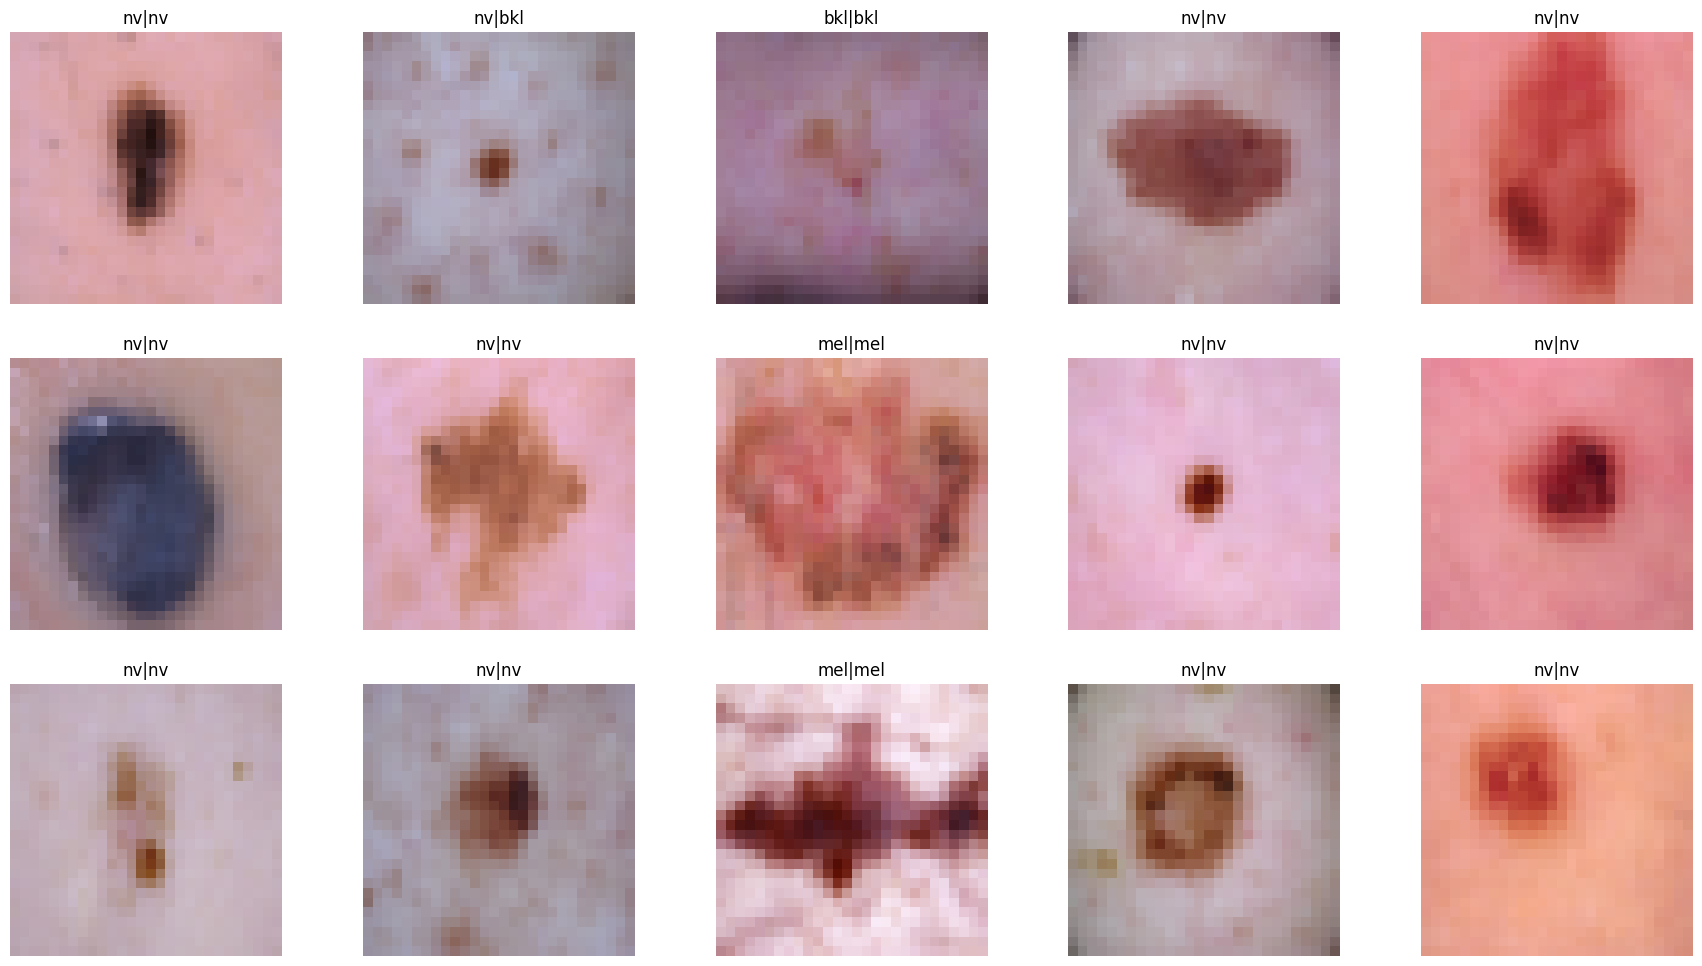

In [43]:
#model = keras.models.load_model('Skin_Cancer.sav')
test_model(model, X_test_orig, Y_test_orig)

# Con otros datos

In [ ]:
data.head()
data.iloc[2]

,index,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path,image_pixel,label
0,5007,HAM_0006322,ISIC_0030309,nv,follow_up,55,male,foot,Melanocytic nevi (nv),../input/skin-cancer-mnist-ham10000/ham10000_i...,"[[[237, 159, 171], [238, 158, 173], [241, 161,...",0
1,4478,HAM_0003084,ISIC_0026191,nv,follow_up,45,female,upper extremity,Melanocytic nevi (nv),../input/skin-cancer-mnist-ham10000/ham10000_i...,"[[[219, 112, 131], [223, 119, 136], [224, 121,...",0
2,4477,HAM_0002093,ISIC_0027032,nv,follow_up,45,female,back,Melanocytic nevi (nv),../input/skin-cancer-mnist-ham10000/ham10000_i...,"[[[234, 134, 155], [238, 140, 164], [234, 130,...",0
3,4476,HAM_0003701,ISIC_0027191,nv,follow_up,45,female,lower extremity,Melanocytic nevi (nv),../input/skin-cancer-mnist-ham10000/ham10000_i...,"[[[214, 121, 154], [216, 124, 159], [218, 124,...",0
4,4475,HAM_0003806,ISIC_0028667,nv,follow_up,45,female,lower extremity,Melanocytic nevi (nv),../input/skin-cancer-mnist-ham10000/ham10000_i...,"[[[234, 146, 167], [236, 149, 171], [233, 149,...",0


index                                                        4477
lesion_id                                             HAM_0002093
image_id                                             ISIC_0027032
dx                                                             nv
dx_type                                                 follow_up
age                                                            45
sex                                                        female
localization                                                 back
cell_type                                   Melanocytic nevi (nv)
path            ../input/skin-cancer-mnist-ham10000/ham10000_i...
image_pixel     [[[234, 134, 155], [238, 140, 164], [234, 130,...
label                                                           0
Name: 2, dtype: object

In [ ]:
'''單張圖片的預測1'''
one_picture_predict_data = data.iloc[2]
print(one_picture_predict_data)
print(one_picture_predict_data.dx)
#print(one_picture_predict_data.image_pixel)
y_value = reverse_label_mapping.get(one_picture_predict_data.dx)
print(y_value)


one_picture_predict_data.image_pixel.shape
new_one = one_picture_predict_data.image_pixel.reshape((1,28,28,3))
model.predict(new_one)

'單張圖片的預測1'

index                                                        4477
lesion_id                                             HAM_0002093
image_id                                             ISIC_0027032
dx                                                             nv
dx_type                                                 follow_up
age                                                            45
sex                                                        female
localization                                                 back
cell_type                                   Melanocytic nevi (nv)
path            ../input/skin-cancer-mnist-ham10000/ham10000_i...
image_pixel     [[[234, 134, 155], [238, 140, 164], [234, 130,...
label                                                           0
Name: 2, dtype: object
nv
0


(28, 28, 3)

array([[1.0000000e+00, 1.6444014e-13, 5.8435229e-10, 3.1058898e-16,
        1.2863705e-20, 1.7683191e-24, 3.7946753e-23]], dtype=float32)

In [ ]:
'''單張圖片的預測2'''
print(data.iloc[2].path)
im = np.asarray(Image.open(data.iloc[2].path))
im.shape
im = im.reshape((1,450,600,3))
im.shape
new_one = one_picture_predict_data.image_pixel.reshape((1,28,28,3))
model.predict(new_one)

'單張圖片的預測2'

../input/skin-cancer-mnist-ham10000/ham10000_images_part_1/ISIC_0027032.jpg


(450, 600, 3)

(1, 450, 600, 3)

array([[1.0000000e+00, 1.6444014e-13, 5.8435229e-10, 3.1058898e-16,
        1.2863705e-20, 1.7683191e-24, 3.7946753e-23]], dtype=float32)